# One-Hot Linear Model (Logistic Regression)

Using the class-balanced data.

# Imports and Setup

Common imports and standardized code for importing the relevant data, models, etc., in order to minimize copy-paste/typo errors.


Set the relevant text field (`'abstract'` or `'title'`) and whether we are working with `'one-hot'` or `'tokenized'` text.  

Raw data was prepared with a max of 256 words for abstracts and 16 for titles. The insertion of spaces around punctuation increases the effective word count, and exploration shows that nearly all of the data is captured by increasing the SEQ_LEN by 50%.

In [ ]:
TEXT_FIELD = 'title'
TEXT_ENCODING = 'one-hot'
assert TEXT_FIELD in ('abstract', 'title'), 'TEXT_FIELD must be one of "title" or "abstract".'
assert TEXT_ENCODING in ('one-hot', 'tokenized'), 'TEXT_ENCODING must be one of "one-hot" or "tokenized".'
# The above choices determine the relevant sequence length of the data.
if TEXT_ENCODING == 'one-hot':
    SEQ_LEN = 128 if TEXT_FIELD == 'title' else 2048
else:
    SEQ_LEN = int(1.5 * 16) if TEXT_FIELD == 'title' else int(1.5 * 256)

Imports and colab setup

In [ ]:
%%capture import_capture --no-stder
# Jupyter magic methods
# For auto-reloading when external modules are changed
%load_ext autoreload
%autoreload 2
# For showing plots inline
%matplotlib inline

# pip installs needed in Colab for arxiv_vixra_models
!pip install wandb
!pip install pytorch-lightning
!pip install unidecode
# Update sklearn
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option(u'float_format', '{:f}'.format)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import seaborn as sns
import torch
import wandb

`wandb` log in:

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Google drive access

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/arxiv_vixra'
assert FOLDERNAME is not None, "[!] Enter the foldername."
# For importing modules stored in FOLDERNAME or a subdirectory thereof:
import sys
sys.path.append(FOLDERNAME)

Mounted at /content/drive


Import my models, loaders, and utility functions:

In [ ]:
import arxiv_vixra_models as avm

Set the model, datamodule, and text decoder to be instantianted in the notebook:

In [ ]:
notebook_model = avm.LitOneHotFC
notebook_datamodule = avm.OneHotCharDataModuleAV
notebook_encoder = avm.one_hot_encoding 
notebook_decoder = avm.one_hot_decoding 
notebook_wandb_callback = avm.WandbAVPredictionCallback

Copy data to cwd for speed.

In [ ]:
train_data_file_name = 'balanced_filtered_normalized_data_train.feather'
val_data_file_name = 'balanced_filtered_normalized_data_validation.feather'
SUBDIR = '/data/data_splits/'
train_data_path = FOLDERNAME + SUBDIR + train_data_file_name
val_data_path = FOLDERNAME + SUBDIR + val_data_file_name
if TEXT_ENCODING == 'one-hot':
    tokens_file_name = 'normalized_char_set.feather'
elif TEXT_FIELD == 'abstract':
    tokens_file_name = 'balanced_abstract_normalized_vocab.feather'
else:
    tokens_file_name = 'balanced_title_normalized_vocab.feather'
tokens_path = FOLDERNAME + SUBDIR + tokens_file_name
!cp '{train_data_path}' .
!cp '{val_data_path}' .
!cp '{tokens_path}' .
train_data_df = pd.read_feather(train_data_file_name)
val_data_df = pd.read_feather(val_data_file_name)
tokens_df = pd.read_feather(tokens_file_name)
if TEXT_ENCODING == 'one-hot':
    text_to_idx = dict(zip(tokens_df.char.values, np.arange(len(tokens_df))))
else:
    # 0 and 1 are reserved for padding and <UNK> for embeddings and not included
    # in tokens_df
    text_to_idx = dict(zip(tokens_df.word.values, np.arange(2, len(tokens_df) + 2)))
    text_to_idx['<PAD>'] = 0
    text_to_idx['<UNK>'] = 1
idx_to_text = {val: key for key, val in text_to_idx.items()}

Computing specs. Save the number of processors to pass as `num_workers` into the Datamodule and cuda availability for other flags.

In [ ]:
# GPU. Save availability to IS_CUDA_AVAILABLE.
gpu_info= !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
  IS_CUDA_AVAILABLE = False
else:
  print(f"GPU\n{50 * '-'}\n", gpu_info, '\n')
  IS_CUDA_AVAILABLE = True

# Memory.
from psutil import virtual_memory, cpu_count
ram_gb = virtual_memory().total / 1e9
print(f"Memory\n{50 * '-'}\n", 'Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb), '\n')

# CPU.
print(f"CPU\n{50 * '-'}\n", f'CPU Processors: {cpu_count()}')
# Determine the number of workers to use in the datamodule
NUM_PROCESSORS = cpu_count()

GPU
--------------------------------------------------
 Fri Jan 14 02:33:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                

Use notebook name as `wandb` `project` string. Remove the file extension and any "Copy of" or "Kopie van" text which arises from copying notebooks and running in parallel. The `entity` needed for various `wandb` calls is just the `wandb` user name.

In [ ]:
from requests import get
PROJECT = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
PROJECT = PROJECT.replace('.ipynb', '').replace('Kopie%20van%20', '').replace('Copy%20of%20', '')
print(PROJECT)
ENTITY = 'garrett361'

balanced_title_linear_one_hot


# Validation Set Filtering

Filter any overlap between the training and validation datasets. Most complete duplicates should have been filtered, but some may not have evaluated as equal prior to text normalization or because they only coinicided in one of the two text columns (e.g., there are distinct papers which share the same title but have different abstracts in the dataset).  We perform strict filtering below.

In [ ]:
val_data_intersections_filtered_df = val_data_df.merge(train_data_df, on=[TEXT_FIELD], how='outer', suffixes=['', '_'], indicator=True).loc[lambda x: x['_merge'] == 'left_only'].iloc[:,:3]
print(f'{len(val_data_df) - len(val_data_intersections_filtered_df)} items removed from val set, {100 * (len(val_data_df) - len(val_data_intersections_filtered_df)) / len(val_data_df):.3f} percent.')

42 items removed from val set, 0.558 percent.


Inspect datasets using `print` and `to_string()` to avoid colab javascript errors

In [ ]:
print(train_data_df.head().to_string())

                                                                                                title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
print(val_data_intersections_filtered_df.head().to_string())

                                                                                                          title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Model Testing

Setting hyperparameters and performing a small test run.

Dictionary args for model and datamodule.

In [ ]:
model_args_dict = {'seq_len': SEQ_LEN,
                  'tokens': tokens_df,
                  'fc_dims': None,
                  'nonlinearity': False,
                   'zero_fc_bias_init': True
                  }
data_args_dict = {'seq_len': SEQ_LEN,
                 'train_data': train_data_df,
                 'val_data': val_data_intersections_filtered_df,
                 'tokens': tokens_df, 
                 'text_column': TEXT_FIELD,
                 'batch_size': 32,
                 'num_workers': NUM_PROCESSORS,
                 'pin_memory': IS_CUDA_AVAILABLE,
                 'persistent_workers': True
                 }

Small test run.

In [ ]:
small_data_module = notebook_datamodule(**{**data_args_dict, **{'sample_size': .25}})
small_data_module.setup()
small_loader = small_data_module.train_dataloader()
small_inputs, small_targets = next(iter(small_loader))
# Print the first few input texts
for tensor, source in zip(small_inputs[:3], small_targets[:3]):
    stripped_text = notebook_decoder(tensor, idx_to_text).strip()
    print(f"text: {stripped_text}",
          f'len: {len(stripped_text)}',
          f'source: {source.item()}',
          sep='\n')
small_model = notebook_model(**model_args_dict)
print('Model layers:', small_model)
small_preds, small_losses = small_model.scores_loss(small_inputs, small_targets)
print('\npreds shape:', small_preds.shape)
print('\nactual loss:', small_losses.item())
print('\nexpected approx loss', -np.log(.5))

text: the constrained maximum likelihood estimation for parameters arising from partially identified models
len: 101
source: False
text: improving the neural gpu architecture for algorithm learning
len: 60
source: False
text: heidegger y los " cuadernos negros " : el resurgimiento de la controversia nacionalsocialista
len: 93
source: True
Model layers: LitOneHotFC(
  (train_metrics_dict): ModuleDict(
    (train_acc): Accuracy()
    (train_precision): Precision()
    (train_recall): Recall()
    (train_specificity): Specificity()
    (train_f1): F1()
    (train_auroc): AUROC()
    (train_avg_precision): AveragePrecision()
  )
  (val_metrics_dict): ModuleDict(
    (val_acc): Accuracy()
    (val_precision): Precision()
    (val_recall): Recall()
    (val_specificity): Specificity()
    (val_f1): F1()
    (val_auroc): AUROC()
    (val_avg_precision): AveragePrecision()
  )
  (test_metrics_dict): ModuleDict(
    (test_acc): Accuracy()
    (test_precision): Precision()
    (test_recall): Rec

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



In [ ]:
small_trainer = Trainer(-1 if IS_CUDA_AVAILABLE else 0,
                        max_epochs=1)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1585: UserWarning:

GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.



A `LR finder stopped early due to diverging loss.` here may be due to having too large a batch size, i.e., not enough samples from the datamodule; [see this github discussion](https://github.com/PyTorchLightning/pytorch-lightning/issues/5044)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/lr_find_temp_model_9d3d5e7d-b2f9-4c2f-83ec-9cdd6d8a4c93.ckpt


Suggested lr: 0.002089296130854039


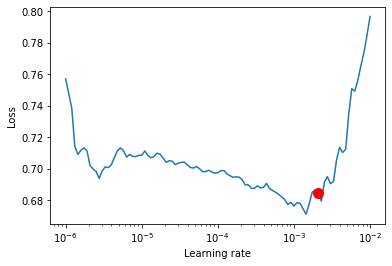

In [ ]:
small_trainer_lr_finder = small_trainer.tuner.lr_find(small_model, datamodule=small_data_module, min_lr=1e-6, max_lr=1e-2)
small_trainer_lr_finder_plot = small_trainer_lr_finder.plot(suggest=True)
small_trainer_suggested_lr = small_trainer_lr_finder.suggestion()
print(f'Suggested lr: {small_trainer_suggested_lr}')

# `wandb` Hyperparameter Tuning



Set fixed hyperparameters and the configuration file for the `wandb` sweep.  Notes on the setup below:
* In `sweep_config['parameters']` we only include those parameters which are to be swept over.
* All fixed parameters will put in `sweep_fixed_model_args_dict`.
* The hyperparameters chosen by `wandb` from `sweep_config` are merged with those from `sweep_fixed_model_args_dict` and passed to the model.
* It is simplest to only sweep over hyperparameters which don't change the size of the model so that we can optimize with a single `batch_size`.  This also helps prevent `CUDA` memory errors which can occur if the sweep generates a model which is too large for the given `batch_size`.
* Pass a `count: int` arg to `wandb.agent` to limit the number of models trained. Without, the training runs indefinitely.

In [ ]:
sweep_fixed_model_args_dict = {**model_args_dict, **{'save_models_to_wandb': True}}

sweep_config = {'method': 'random'}
sweep_config['parameters'] =  {'lr': {'distribution': 'log_uniform',
                                      'min': np.log(1e-4).item(),
                                      'max': np.log(1e-2).item()
                                      },                          
                               }

Re-instantiate data using the full dataset and a non-trivial batch size.  Implement truncated backpropagation through time, if desired, and set the `max_epochs` of the run and other desired parameters in dictionary for the trainer, which is also appended to `sweep_fixed_model_args_dict` for logging purposes.

In [ ]:
# Setting 'batch_size' in data_args_dict controls the batch size, while setting
# this key in sweep_fixed_model_args_dict just lets wandb track this hyperparameter.
sweep_data_args_dict = deepcopy(data_args_dict)
sweep_data_args_dict['batch_size'] = sweep_fixed_model_args_dict['batch_size'] = 4096

# Set max_epochs in a dict, along with any other optional trainer kwargs.
sweep_trainer_dict = {'max_epochs': 32,
               }

# Merge sweep_trainer_dict into sweep_fixed_model_args_dict for logging purposes.
sweep_fixed_model_args_dict = {**sweep_fixed_model_args_dict, **sweep_trainer_dict}


def sweep_val_examples(sample_size=512,
                       datamodule_args=sweep_data_args_dict):
    """Taking random samples from the validation set for callback visualization.
    """
    val_sample_module = notebook_datamodule(**{**datamodule_args,
                                               **{'sample_size': sample_size}})
    val_sample_module.setup()
    val_sample  = next(iter(val_sample_module.val_dataloader()))
    return val_sample

def sweep_trainer():
    """Encapsulating the trainer used for wandb sweeps.
    """
    trainer = Trainer(logger=WandbLogger(),
                      gpus=-1 if IS_CUDA_AVAILABLE else 0,
                      log_every_n_steps=5,
                      callbacks=[notebook_wandb_callback(val_sample=sweep_val_examples(),
                                                         decoder_fn=notebook_decoder,
                                                         decoder_dict=idx_to_text,
                                                         labels=('arxiv', 'vixra')),
                                 EarlyStopping(monitor='val_acc',
                                               mode='max',
                                               check_on_train_epoch_end=False,
                                               patience=5,
                                               verbose=True)
                                 ],
                      num_sanity_val_steps=-1,
                      **sweep_trainer_dict
                      )
    return trainer

def sweep_iteration():
    """The wandb sweep iteration function. To be passed to wandb.agent.
    """
    # There seems to be a 128 char limit on the group_str
    group_str = '-'.join(sorted([f'{key}_{val}' for key, val in sweep_fixed_model_args_dict.items() if key != 'tokens']))[:128]
    with wandb.init(group=group_str) as run:
        data = notebook_datamodule(**sweep_data_args_dict)
        config = wandb.config
        # Overwrite the random run names chosen by wandb.
        run.name = '-'.join(sorted([f'{key}_{val}' for key, val in config.items()]))[:128]
        # Merge config into remaining parameters.
        config = {**sweep_fixed_model_args_dict, **config}
        model = notebook_model(**config)
        print(50 * '-',
              'Model Architecture:',
              model,
              50 * '-',
              sep='\n')
        trainer = sweep_trainer()
        trainer.fit(model, 
                    datamodule=data)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: aapyr8yh
Sweep URL: https://wandb.ai/garrett361/balanced_title_linear_one_hot/sweeps/aapyr8yh


In [ ]:
wandb.agent(sweep_id, function=sweep_iteration, count=3)
# Sweeps will generate a huge number of plots, if not closed.
plt.close("all")

wandb: Agent Starting Run: ypgyq2k5 with config:
wandb: 	lr: 0.001306848447792953
wandb: Currently logged in as: garrett361 (use `wandb login --relogin` to force relogin)


--------------------------------------------------
Model Architecture:
LitOneHotFC(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (layers): ModuleList(
    (0): Linear(in_features=8832, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.5028044581413269
Validation Loss: 0.7299559116363525
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.5028044581413269
Validation Loss: 0.7299559116363525


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6165865659713745
Validation Loss: 0.674313485622406
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.6165865659713745
Validation Loss: 0.674313485622406


Metric val_acc improved. New best score: 0.617


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6197916865348816
Validation Loss: 0.627252459526062
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6197916865348816
Validation Loss: 0.627252459526062


Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.620


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.655715823173523
Validation Loss: 0.5996323227882385
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.655715823173523
Validation Loss: 0.5996323227882385


Metric val_acc improved by 0.036 >= min_delta = 0.0. New best score: 0.656


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6722756624221802
Validation Loss: 0.5903621912002563
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6722756624221802
Validation Loss: 0.5903621912002563


Metric val_acc improved by 0.017 >= min_delta = 0.0. New best score: 0.672


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.6754807829856873
Validation Loss: 0.5845626592636108
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6754807829856873
Validation Loss: 0.5845626592636108


Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.675


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 53
Epoch: 5
Validation accuracy: 0.6888354420661926
Validation Loss: 0.581000566482544
Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.6888354420661926
Validation Loss: 0.581000566482544


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
Metric val_acc improved by 0.013 >= min_delta = 0.0. New best score: 0.689


Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 62
Epoch: 6
Validation accuracy: 0.7003205418586731
Validation Loss: 0.58086097240448
Saved best val_loss at global step: 62
Epoch: 6
Validation accuracy: 0.7003205418586731
Validation Loss: 0.58086097240448


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 71
Epoch: 7
Validation accuracy: 0.6943109035491943
Validation Loss: 0.577467679977417


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 80
Epoch: 8
Validation accuracy: 0.69017094373703
Validation Loss: 0.5767172574996948


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 89
Epoch: 9
Validation accuracy: 0.6981837749481201
Validation Loss: 0.5753529667854309


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 98
Epoch: 10
Validation accuracy: 0.6965811848640442
Validation Loss: 0.5743241906166077


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 107
Epoch: 11
Validation accuracy: 0.6999198794364929
Validation Loss: 0.5738488435745239


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▁▄▆▆▇██████
best_val_loss,█▅▃▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▇▇▇▇██
global_step,▁▂▂▃▃▄▄▅▆▆▇▇█
train_acc,▁▅▅▆▇▇▇█████
train_auc_roc,▁▄▆▆▇▇▇█████
train_average_precision,▁▄▆▆▇▇▇█████
train_f1,▁▄▄▅▆▆▇▇▇███
train_loss,█▅▃▃▂▂▂▂▁▁▁▁
train_precision,▁▅▆▇████████
train_recall,▁▄▃▄▅▅▆▇▇▇██


wandb: Agent Starting Run: xxt5hpef with config:
wandb: 	lr: 0.0002680869184261095


--------------------------------------------------
Model Architecture:
LitOneHotFC(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (layers): ModuleList(
    (0): Linear(in_features=8832, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.46300747990608215
Validation Loss: 0.7418582439422607
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.46300747990608215
Validation Loss: 0.7418582439422607


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.6079059839248657
Validation Loss: 0.6563867330551147
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.6079059839248657
Validation Loss: 0.6563867330551147


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6434294581413269
Validation Loss: 0.6386460661888123
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6434294581413269
Validation Loss: 0.6386460661888123


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6510416865348816
Validation Loss: 0.626512885093689
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6510416865348816
Validation Loss: 0.626512885093689


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6511752009391785
Validation Loss: 0.617579460144043
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6511752009391785
Validation Loss: 0.617579460144043


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.6543803215026855
Validation Loss: 0.6111764907836914
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6543803215026855
Validation Loss: 0.6111764907836914


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.65357905626297
Validation Loss: 0.605313241481781


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 62
Epoch: 6
Validation accuracy: 0.6570512652397156
Validation Loss: 0.6003437042236328
Saved best val_loss at global step: 62
Epoch: 6
Validation accuracy: 0.6570512652397156
Validation Loss: 0.6003437042236328


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 7
Validation accuracy: 0.6651976704597473
Validation Loss: 0.5962616205215454
Saved best val_loss at global step: 71
Epoch: 7
Validation accuracy: 0.6651976704597473
Validation Loss: 0.5962616205215454


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 80
Epoch: 8
Validation accuracy: 0.6685363054275513
Validation Loss: 0.5928194522857666
Saved best val_loss at global step: 80
Epoch: 8
Validation accuracy: 0.6685363054275513
Validation Loss: 0.5928194522857666


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 9
Validation accuracy: 0.6716079115867615
Validation Loss: 0.589892566204071
Saved best val_loss at global step: 89
Epoch: 9
Validation accuracy: 0.6716079115867615
Validation Loss: 0.589892566204071


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 98
Epoch: 10
Validation accuracy: 0.6708066463470459
Validation Loss: 0.5875067710876465


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 11
Validation accuracy: 0.6802884340286255
Validation Loss: 0.5853599309921265
Saved best val_loss at global step: 107
Epoch: 11
Validation accuracy: 0.6802884340286255
Validation Loss: 0.5853599309921265


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 116
Epoch: 12
Validation accuracy: 0.6817574501037598
Validation Loss: 0.5834946632385254
Saved best val_loss at global step: 116
Epoch: 12
Validation accuracy: 0.6817574501037598
Validation Loss: 0.5834946632385254


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 125
Epoch: 13
Validation accuracy: 0.6821581125259399
Validation Loss: 0.5818563103675842
Saved best val_loss at global step: 125
Epoch: 13
Validation accuracy: 0.6821581125259399
Validation Loss: 0.5818563103675842


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 134
Epoch: 14
Validation accuracy: 0.6830929517745972
Validation Loss: 0.5804508924484253
Saved best val_loss at global step: 134
Epoch: 14
Validation accuracy: 0.6830929517745972
Validation Loss: 0.5804508924484253


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 143
Epoch: 15
Validation accuracy: 0.6887019276618958
Validation Loss: 0.579404354095459
Saved best val_loss at global step: 143
Epoch: 15
Validation accuracy: 0.6887019276618958
Validation Loss: 0.579404354095459


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 152
Epoch: 16
Validation accuracy: 0.6903044581413269
Validation Loss: 0.5785646438598633
Saved best val_loss at global step: 152
Epoch: 16
Validation accuracy: 0.6903044581413269
Validation Loss: 0.5785646438598633


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 161
Epoch: 17
Validation accuracy: 0.6907051205635071
Validation Loss: 0.5774441361427307
Saved best val_loss at global step: 161
Epoch: 17
Validation accuracy: 0.6907051205635071
Validation Loss: 0.5774441361427307


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 170
Epoch: 18
Validation accuracy: 0.6933760643005371
Validation Loss: 0.576746940612793
Saved best val_loss at global step: 170
Epoch: 18
Validation accuracy: 0.6933760643005371
Validation Loss: 0.576746940612793


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 179
Epoch: 19
Validation accuracy: 0.6931089758872986
Validation Loss: 0.5755999088287354


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 188
Epoch: 20
Validation accuracy: 0.6868322491645813
Validation Loss: 0.5753297805786133


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 197
Epoch: 21
Validation accuracy: 0.686965823173523
Validation Loss: 0.5747000575065613


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 206
Epoch: 22
Validation accuracy: 0.6916399598121643
Validation Loss: 0.5737073421478271


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 215
Epoch: 23
Validation accuracy: 0.689636766910553
Validation Loss: 0.5735236406326294


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▄▅▅▅▅▅▆▆▆▆▇▇▇▇█████████
best_val_loss,█▇▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
global_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇██
train_acc,▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
train_auc_roc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇██████████
train_average_precision,▁▅▅▆▆▆▇▇▇▇▇▇▇▇██████████
train_f1,▁▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_precision,▁▅▆▆▇▇▇▇▇███████████████
train_recall,▁▅▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████


wandb: Agent Starting Run: 8kdkp2qc with config:
wandb: 	lr: 0.0001223689669564527


--------------------------------------------------
Model Architecture:
LitOneHotFC(
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (test_acc): Accuracy()
  (train_precision): Precision()
  (val_precision): Precision()
  (test_precision): Precision()
  (train_recall): Recall()
  (val_recall): Recall()
  (test_recall): Recall()
  (train_specificity): Specificity()
  (val_specificity): Specificity()
  (test_specificity): Specificity()
  (train_f1): F1()
  (val_f1): F1()
  (test_f1): F1()
  (train_auc_roc): AUROC()
  (val_auc_roc): AUROC()
  (test_auc_roc): AUROC()
  (train_average_precision): AveragePrecision()
  (val_average_precision): AveragePrecision()
  (test_average_precision): AveragePrecision()
  (layers): ModuleList(
    (0): Linear(in_features=8832, out_features=1, bias=True)
  )
)
--------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:342: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created ins

Validation sanity check: 0it [00:00, ?it/s]

Saved best val_acc at global step: 0
Epoch: 0
Validation accuracy: 0.4724893271923065
Validation Loss: 0.7272829413414001
Saved best val_loss at global step: 0
Epoch: 0
Validation accuracy: 0.4724893271923065
Validation Loss: 0.7272829413414001


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 8
Epoch: 0
Validation accuracy: 0.5396634340286255
Validation Loss: 0.6816861033439636
Saved best val_loss at global step: 8
Epoch: 0
Validation accuracy: 0.5396634340286255
Validation Loss: 0.6816861033439636


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 17
Epoch: 1
Validation accuracy: 0.6064369678497314
Validation Loss: 0.6584711670875549
Saved best val_loss at global step: 17
Epoch: 1
Validation accuracy: 0.6064369678497314
Validation Loss: 0.6584711670875549


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 26
Epoch: 2
Validation accuracy: 0.6219283938407898
Validation Loss: 0.6471059918403625
Saved best val_loss at global step: 26
Epoch: 2
Validation accuracy: 0.6219283938407898
Validation Loss: 0.6471059918403625


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 35
Epoch: 3
Validation accuracy: 0.6458333134651184
Validation Loss: 0.6394274234771729
Saved best val_loss at global step: 35
Epoch: 3
Validation accuracy: 0.6458333134651184
Validation Loss: 0.6394274234771729


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 44
Epoch: 4
Validation accuracy: 0.6471688151359558
Validation Loss: 0.6322714686393738
Saved best val_loss at global step: 44
Epoch: 4
Validation accuracy: 0.6471688151359558
Validation Loss: 0.6322714686393738


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 53
Epoch: 5
Validation accuracy: 0.6459668874740601
Validation Loss: 0.6272451877593994


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 62
Epoch: 6
Validation accuracy: 0.6479700803756714
Validation Loss: 0.6230665445327759
Saved best val_loss at global step: 62
Epoch: 6
Validation accuracy: 0.6479700803756714
Validation Loss: 0.6230665445327759


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 71
Epoch: 7
Validation accuracy: 0.6547809839248657
Validation Loss: 0.6195594668388367
Saved best val_loss at global step: 71
Epoch: 7
Validation accuracy: 0.6547809839248657
Validation Loss: 0.6195594668388367


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 80
Epoch: 8
Validation accuracy: 0.6554487347602844
Validation Loss: 0.6161118745803833
Saved best val_loss at global step: 80
Epoch: 8
Validation accuracy: 0.6554487347602844
Validation Loss: 0.6161118745803833


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 89
Epoch: 9
Validation accuracy: 0.655715823173523
Validation Loss: 0.6129376888275146
Saved best val_loss at global step: 89
Epoch: 9
Validation accuracy: 0.655715823173523
Validation Loss: 0.6129376888275146


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 98
Epoch: 10
Validation accuracy: 0.6542468070983887
Validation Loss: 0.6101015210151672


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 107
Epoch: 11
Validation accuracy: 0.6577190160751343
Validation Loss: 0.6074478626251221
Saved best val_loss at global step: 107
Epoch: 11
Validation accuracy: 0.6577190160751343
Validation Loss: 0.6074478626251221


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 116
Epoch: 12
Validation accuracy: 0.6614583134651184
Validation Loss: 0.6052933931350708
Saved best val_loss at global step: 116
Epoch: 12
Validation accuracy: 0.6614583134651184
Validation Loss: 0.6052933931350708


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 125
Epoch: 13
Validation accuracy: 0.6631944179534912
Validation Loss: 0.603157103061676
Saved best val_loss at global step: 125
Epoch: 13
Validation accuracy: 0.6631944179534912
Validation Loss: 0.603157103061676


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 134
Epoch: 14
Validation accuracy: 0.6641292572021484
Validation Loss: 0.6010440587997437
Saved best val_loss at global step: 134
Epoch: 14
Validation accuracy: 0.6641292572021484
Validation Loss: 0.6010440587997437


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 143
Epoch: 15
Validation accuracy: 0.6609241366386414
Validation Loss: 0.599196195602417


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 152
Epoch: 16
Validation accuracy: 0.6682692170143127
Validation Loss: 0.5972133874893188
Saved best val_loss at global step: 152
Epoch: 16
Validation accuracy: 0.6682692170143127
Validation Loss: 0.5972133874893188


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 161
Epoch: 17
Validation accuracy: 0.676148533821106
Validation Loss: 0.596886157989502
Saved best val_loss at global step: 161
Epoch: 17
Validation accuracy: 0.676148533821106
Validation Loss: 0.596886157989502


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 170
Epoch: 18
Validation accuracy: 0.671340823173523
Validation Loss: 0.5940099358558655


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 179
Epoch: 19
Validation accuracy: 0.6701388955116272
Validation Loss: 0.592603325843811


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 188
Epoch: 20
Validation accuracy: 0.6776175498962402
Validation Loss: 0.5915781259536743
Saved best val_loss at global step: 188
Epoch: 20
Validation accuracy: 0.6776175498962402
Validation Loss: 0.5915781259536743


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 197
Epoch: 21
Validation accuracy: 0.679353654384613
Validation Loss: 0.5906403660774231
Saved best val_loss at global step: 197
Epoch: 21
Validation accuracy: 0.679353654384613
Validation Loss: 0.5906403660774231


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 206
Epoch: 22
Validation accuracy: 0.6741452813148499
Validation Loss: 0.5888116359710693


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 215
Epoch: 23
Validation accuracy: 0.6784188151359558
Validation Loss: 0.5878148078918457


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 224
Epoch: 24
Validation accuracy: 0.6794871687889099
Validation Loss: 0.5867475271224976
Saved best val_loss at global step: 224
Epoch: 24
Validation accuracy: 0.6794871687889099
Validation Loss: 0.5867475271224976


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 233
Epoch: 25
Validation accuracy: 0.6841613054275513
Validation Loss: 0.5860348343849182
Saved best val_loss at global step: 233
Epoch: 25
Validation accuracy: 0.6841613054275513
Validation Loss: 0.5860348343849182


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 242
Epoch: 26
Validation accuracy: 0.6838942170143127
Validation Loss: 0.5850118398666382


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 251
Epoch: 27
Validation accuracy: 0.68482905626297
Validation Loss: 0.5841537714004517
Saved best val_loss at global step: 251
Epoch: 27
Validation accuracy: 0.68482905626297
Validation Loss: 0.5841537714004517


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 260
Epoch: 28
Validation accuracy: 0.6776175498962402
Validation Loss: 0.5835564136505127


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 269
Epoch: 29
Validation accuracy: 0.6817574501037598
Validation Loss: 0.5825939774513245


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_loss at global step: 278
Epoch: 30
Validation accuracy: 0.6804220080375671
Validation Loss: 0.5819152593612671


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

Validating: 0it [00:00, ?it/s]

Saved best val_acc at global step: 287
Epoch: 31
Validation accuracy: 0.6860309839248657
Validation Loss: 0.5811481475830078
Saved best val_loss at global step: 287
Epoch: 31
Validation accuracy: 0.6860309839248657
Validation Loss: 0.5811481475830078


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/roc_curve.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:139: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until exp

best_val_acc,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
best_val_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_acc,▁▃▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_auc_roc,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████
train_average_precision,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
train_f1,▁▃▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_precision,▁▅▆▆▇▇▇▇▇▇▇▇▇██▇████████████████
train_recall,▁▃▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████


# Inspecting the Best Model

Load in the best model amongst all runs recorded in `wandb` for this notebook, as judged by `val_acc`.

In [ ]:
wandb_api = wandb.Api()
notebook_runs = wandb_api.runs(ENTITY + "/" + PROJECT) 

run_cats = ('best_val_acc','config', 'name', 'wandb_path')
notebook_runs_dict = {key: [] for key in run_cats}

for run in notebook_runs:
    run_json = run.summary._json_dict
    if 'best_val_acc' in run_json:
        notebook_runs_dict['best_val_acc'].append(run_json['best_val_acc'])
        notebook_runs_dict['config'].append({key: val for key, val in run.config.items()})
        notebook_runs_dict['name'].append(run.name)
        notebook_runs_dict['wandb_path'].append('/'.join(run.path))
    
notebook_runs_df = pd.DataFrame(notebook_runs_dict).sort_values(by='best_val_acc', ascending=False).reset_index(drop=True)
notebook_runs_df.head()

,best_val_acc,config,name,wandb_path
0,0.704060,"{'lr': 0.006569476238807622, 'fc_dims': 'None'...",lr_0.006569476238807622,garrett361/balanced_title_linear_one_hot/x1rplmaq
1,0.700321,"{'lr': 0.001306848447792953, 'fc_dims': 'None'...",lr_0.001306848447792953,garrett361/balanced_title_linear_one_hot/ypgyq2k5
2,0.699252,"{'lr': 0.0005910362628440994, 'fc_dims': 'None...",lr_0.0005910362628440994_no_hiddens,garrett361/balanced_title_linear_one_hot/1wrx8n3k
3,0.696581,"{'lr': 0.0005100166799891927, 'fc_dims': 'None...",lr_0.0005100166799891927,garrett361/balanced_title_linear_one_hot/aada3okd
4,0.693376,"{'lr': 0.0002680869184261095, 'fc_dims': 'None...",lr_0.0002680869184261095,garrett361/balanced_title_linear_one_hot/xxt5hpef


Save the state dict for the best model locally and re-build the corresponding model.

In [ ]:
best_model_wandb_path = notebook_runs_df.iloc[0].wandb_path
best_model_config = notebook_runs_df.iloc[0].config.copy()
# wandb also stores None values in the config dict as a string literal. Need to
# fix these entries, annoyingly.
for key, val in best_model_config.items():
    if val == 'None':
        best_model_config[key] = None
# Also need to add the tokens arg back in, which isn't synced with wandb.
best_model_config['tokens'] = tokens_df
!rm 'model_best_val_acc.pt'
wandb.restore('model_best_val_acc.pt', run_path = best_model_wandb_path)
best_model = notebook_model(**best_model_config)
best_model.load_state_dict(torch.load('model_best_val_acc.pt'))

rm: cannot remove 'model_best_val_acc.pt': No such file or directory


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning:

Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.



<All keys matched successfully>

Also write the best models (by `val_loss` and `val_acc`) to our final models folder:

In [ ]:
wandb.restore('model_best_val_loss.pt', run_path = best_model_wandb_path)
!cp 'model_best_val_acc.pt' "{FOLDERNAME + '/final_models/' + PROJECT + '_val_acc.pt'}"
!cp 'model_best_val_loss.pt' "{FOLDERNAME + '/final_models/' + PROJECT + '_val_loss.pt'}"

Inspect the form of the weight layer, re-shaped to reflect the one-hot encoding again.

In [ ]:
best_model_weights = best_model.fc_layers[0].weight.detach().view(1, -1, len(tokens_df))
best_model_bias = best_model.fc_layers[0].bias.detach()

Check out the weights for the final positions in the sequence, taking the top and bottom 5 values. Create small dataframes with the associated characters and weights.

In [ ]:
best_model_weights_last_topk = best_model_weights[:,-1,:].topk(5, dim=-1)
best_model_weights_last_bottomk = best_model_weights[:,-1,:].topk(5, dim=-1, largest=False)
best_model_weights_last_topk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_last_topk.indices.view(-1)].char.values, 'weight': best_model_weights_last_topk.values.view(-1).detach()})
best_model_weights_last_bottomk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_last_bottomk.indices.view(-1)].char.values, 'weight': best_model_weights_last_bottomk.values.view(-1).detach()})

In [ ]:
best_model_weights_last_topk_df.append(best_model_weights_last_bottomk_df, ignore_index=True)

,char,weight
0,.,0.295374
1,),0.126281
2,t,0.062229
3,w,0.053102
4,r,0.047952
5,$,-0.203156
6,c,-0.079901
7,3,-0.054232
8,b,-0.052899
9,g,-0.043184


Visualizing the above by inspecting examples and computing the probability that a paper is from `arXiv` or `viXra` given that it ends with a certain character and vice versa:

In [ ]:
def visualize_ends_with(char, df, num=5):
    """View num examples from df which end with char and compute related
    conditional probabilities.
    """
    with pd.option_context('display.max_colwidth', SEQ_LEN):
        mask = df[TEXT_FIELD].str.endswith(char)
        filtered_df = df[mask]
        display(filtered_df[[TEXT_FIELD, 'source']].sample(num))
        print(f"P(viXra|{TEXT_FIELD} ends with {char}): {(filtered_df.source == 'vixra').mean()}")
        print(f"P({TEXT_FIELD} ends with {char}|viXra): {(filtered_df.source == 'vixra').sum() / (df.source == 'vixra').sum()}")
        print(50 * '-')
        print(f"P(arXiv|{TEXT_FIELD} ends with {char}): {(filtered_df.source == 'arxiv').mean()}")
        print(f"P({TEXT_FIELD} ends with {char}|arXiv): {(filtered_df.source == 'arxiv').sum() / (df.source == 'arxiv').sum()}")

In [ ]:
visualize_ends_with('!', train_data_df)

,title,source
20923,( 0 / 0 ) = 0 = refuted !,vixra
20032,geoengineering has wrong target !,vixra
12001,funny problems !,vixra
16867,stop new fossil fuel projects !,vixra
1787,many returns in mathematics !,vixra


P(viXra|title ends with !): 0.8928571428571429
P(title ends with !|viXra): 0.0014227989300552046
--------------------------------------------------
P(arXiv|title ends with !): 0.10714285714285714
P(title ends with !|arXiv): 0.00017073587160662456


In [ ]:
visualize_ends_with('$', train_data_df)

,title,source
13791,high - pressure structural evolution of disordered polymeric cs $ _ 2 $,arxiv
25808,landau - ginzburg / calabi - yau correspondence of all genera for elliptic orbifold $ \ mathbb { p } ^ 1 $,arxiv
27565,on a family of a linear maps from $ m _ { n } ( \ mathbb { c } ) $ to $ m _ { n ^ { 2 } } ( \ mathbb { c } ) $,arxiv
3997,vacuum structure in 5d so ( 10 ) gut on $ s ^ 1 / z _ 2 $,arxiv
27486,cosmic reionization on computers : the galaxy - halo connection between $ 5 \ leq z \ leq10 $,arxiv


P(viXra|title ends with $): 0.04716981132075472
P(title ends with $|viXra): 0.0005691195720220818
--------------------------------------------------
P(arXiv|title ends with $): 0.9528301886792453
P(title ends with $|arXiv): 0.011496215354846052


In [ ]:
visualize_ends_with('b', train_data_df)

,title,source
1720,ground - based near - ir observations of the secondary eclipse of corot - 2b,arxiv
18189,relaxation of bose - einstein condensates of magnons in magneto - textural traps in superfluid $ ^ 3 $ he - b,arxiv
23075,revealing the nature of magnetic phases in the semi - heusler alloy cu0 . 85ni0 . 15mnsb,arxiv
29848,open source software development challenges : a systematic literature review on github,arxiv
456,a cosmology forecast toolkit - - cosmolib,arxiv


P(viXra|title ends with b): 0.25
P(title ends with b|viXra): 0.0006829434864264982
--------------------------------------------------
P(arXiv|title ends with b): 0.75
P(title ends with b|arXiv): 0.002048830459279495


Same analysis for starting position:

In [ ]:
best_model_weights_first_topk = best_model_weights[:,0,:].topk(5, dim=-1)
best_model_weights_first_bottomk = best_model_weights[:,0,:].topk(5, dim=-1, largest=False)
best_model_weights_first_topk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_first_topk.indices.view(-1)].char.values, 'weight': best_model_weights_first_topk.values.view(-1).detach()})
best_model_weights_first_bottomk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_first_bottomk.indices.view(-1)].char.values, 'weight': best_model_weights_first_bottomk.values.view(-1).detach()})

In [ ]:
best_model_weights_first_topk_df.append(best_model_weights_first_bottomk_df, ignore_index=True)

,char,weight
0,j,0.013536
1,l,0.010837
2,n,0.010009
3,1,0.009706
4,c,0.009492
5,g,-0.019932
6,p,-0.016636
7,m,-0.016461
8,d,-0.014759
9,o,-0.013293


Seemingly all noise since the first position is often padding.

In [ ]:
def visualize_starts_with(char, df, num=5):
    """View num examples from df which start with char and compute related
    conditional probabilities.
    """
    with pd.option_context('display.max_colwidth', SEQ_LEN):
        mask = df[TEXT_FIELD].str.startswith(char)
        filtered_df = df[mask]
        display(filtered_df[[TEXT_FIELD, 'source']].sample(num))
        print(f"P(viXra|{TEXT_FIELD} starts with {char}): {(filtered_df.source == 'vixra').mean()}")
        print(f"P({TEXT_FIELD} starts with {char}|viXra): {(filtered_df.source == 'vixra').sum() / (df.source == 'vixra').sum()}")
        print(50 * '-')
        print(f"P(arXiv|{TEXT_FIELD} starts with {char}): {(filtered_df.source == 'arxiv').mean()}")
        print(f"P({TEXT_FIELD} starts with {char}|arXiv): {(filtered_df.source == 'arxiv').sum() / (df.source == 'arxiv').sum()}")

Similar analysis when averaging over sequence positions.

In [ ]:
best_model_weights_mean_topk = best_model_weights.mean(1).topk(5, dim=-1)
best_model_weights_mean_bottomk = best_model_weights.mean(1).topk(5, dim=-1, largest=False)
best_model_weights_mean_topk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_mean_topk.indices.view(-1)].char.values, 'weight': best_model_weights_mean_topk.values.view(-1).detach()})
best_model_weights_mean_bottomk_df = pd.DataFrame.from_dict({'char': tokens_df.iloc[best_model_weights_mean_bottomk.indices.view(-1)].char.values, 'weight': best_model_weights_mean_bottomk.values.view(-1).detach()})

In [ ]:
best_model_weights_mean_topk_df.append(best_model_weights_mean_bottomk_df, ignore_index=True)

,char,weight
0,",",0.013389
1,h,0.012498
2,',0.010195
3,.,0.007097
4,e,0.006145
5,-,-0.036315
6,$,-0.021746
7,b,-0.011665
8,r,-0.010858
9,\,-0.010625


Visualize similarly:

In [ ]:
def visualize_means(char, df, num=5):
    """View num examples from df which contain char and compute related
    conditional probabilities.
    """
    with pd.option_context('display.max_colwidth', SEQ_LEN):
        mask = df[TEXT_FIELD].str.contains(char)
        filtered_df = df[mask]
        display(filtered_df[[TEXT_FIELD, 'source']].head(num))
        print(f"P(viXra|{TEXT_FIELD} contains {char[-1]}): {(filtered_df.source == 'vixra').mean()}")
        print(f"P({TEXT_FIELD} contains {char[-1]}|viXra): {(filtered_df.source == 'vixra').sum() / (df.source == 'vixra').sum()}")
        print(50 * '-')
        print(f"P(arXiv|{TEXT_FIELD} contains {char[-1]}): {(filtered_df.source == 'arxiv').mean()}")
        print(f"P({TEXT_FIELD} contains {char[-1]}|arXiv): {(filtered_df.source == 'arxiv').sum() / (df.source == 'arxiv').sum()}")

In [ ]:
visualize_means('\$', train_data_df)

,title,source
50,subpicosecond $ x $ rotations of atomic clock states,arxiv
67,"classes and equivalence of linear sets in $ pg ( 1 , q ^ n ) $",arxiv
224,weak sequential completeness in banach $ c ( k ) $ - modules of finite multiplicity,arxiv
304,competition of three - dimensional magnetic phases in ca $ _ 2 $ ru $ _ { 1 - x } $ fe $ _ x $ o $ _ 4 $ : a structural pers...,arxiv
490,convergence of glauber dynamic on ising - like models with kac interaction to $ \ phi ^ { 2n } _ 2 $,arxiv


P(viXra|title contains $): 0.044543429844097995
P(title contains $|viXra): 0.0022764782880883272
--------------------------------------------------
P(arXiv|title contains $): 0.955456570155902
P(title contains $|arXiv): 0.04883045927949462


In [ ]:
visualize_means('\-', train_data_df)

,title,source
3,atomic - scale erector,vixra
4,temperature dependence of microwave and thz dielectric response in srn + 1tino3n + 1 ( n = 1 - 4 ),arxiv
7,certain axion - like particles excluded,vixra
11,a cryogenic amplifier for fast real - time detection of single - electron tunneling,arxiv
14,long time existence and bounded scalar curvature in the ricci - harmonic flow,arxiv


P(viXra|title contains -): 0.3276078010377527
P(title contains -|viXra): 0.20841158727448636
--------------------------------------------------
P(arXiv|title contains -): 0.6723921989622472
P(title contains -|arXiv): 0.4277502703317967


In [ ]:
visualize_means('\'', train_data_df)

,title,source
17,the nineteen postulates of einstein ' s special relativity theory,vixra
29,a very exhaustive generalization of de polignac ' s conjecture,vixra
30,thiele ' s differential equation based on markov jump processes with non - countable state space,arxiv
32,extending fourier transformations to hamilton ' s quaternions and clifford ' s geometric algebras,vixra
70,"on a single page , beal conjecture ; equivalent beal conjecture & fermat ' s last theorem proved",vixra


P(viXra|title contains '): 0.6973255055446836
P(title contains '|viXra): 0.06083888224916055
--------------------------------------------------
P(arXiv|title contains '): 0.30267449445531636
P(title contains '|arXiv): 0.0264071481418246


In [ ]:
visualize_means('\_', train_data_df)

,title,source
94,"q _ r - conformal symmetries in 2d nonlocal quantum field theory , categorical representation theory , and virasoro algebra",arxiv
133,can old galaxies at high redshifts and baryon acoustic oscillations constrain h _ 0 ?,arxiv
304,competition of three - dimensional magnetic phases in ca $ _ 2 $ ru $ _ { 1 - x } $ fe $ _ x $ o $ _ 4 $ : a structural pers...,arxiv
425,electronic structure and charge - density wave transition in monolayer vs _ { 2 },arxiv
490,convergence of glauber dynamic on ising - like models with kac interaction to $ \ phi ^ { 2n } _ 2 $,arxiv


P(viXra|title contains _): 0.09292929292929293
P(title contains _|viXra): 0.0026179500313015763
--------------------------------------------------
P(arXiv|title contains _): 0.907070707070707
P(title contains _|arXiv): 0.025553468783791475


Can also look at positional dependence by taking the `mean` over the character dimension

In [ ]:
# Positions most informative of viXra.
best_model_weights.mean(-1).topk(5, dim=-1)

torch.return_types.topk(values=tensor([[0.0053, 0.0018, 0.0017, 0.0013, 0.0012]]), indices=tensor([[127, 125,  18,  40,  50]]))

In [ ]:
# Positions most informative of arXiv.
best_model_weights.mean(-1).topk(5, dim=-1, largest=False)

torch.return_types.topk(values=tensor([[-0.0070, -0.0068, -0.0066, -0.0065, -0.0058]]), indices=tensor([[91, 90, 93, 84, 88]]))

In [ ]:
# Overall most informative positions.
best_model_weights.mean(-1).abs().topk(5, dim=-1)

torch.return_types.topk(values=tensor([[0.0070, 0.0068, 0.0066, 0.0065, 0.0058]]), indices=tensor([[91, 90, 93, 84, 88]]))

So the more informative positions tend to be those towards the end of the sequence, which makes sense given the padding.

We also expect blank spaces to be somewhat informative of viXra titles, which tend to be shorter (since blank spaces were used as padding).  Plot the weights associated with blank space by sequence position along with their cumulatitve sum. Also indicate the mean start positions of arXiv and viXra titles

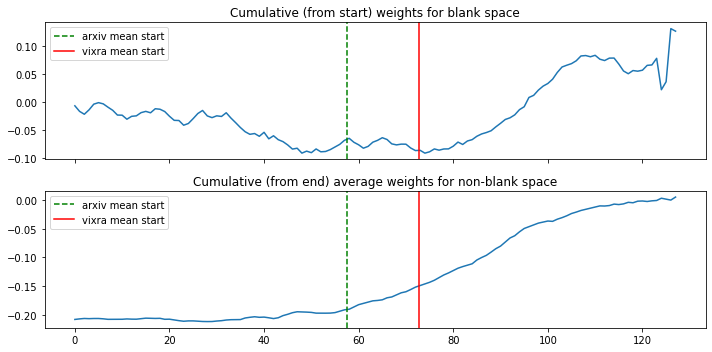

In [ ]:
arxiv_mean_start = SEQ_LEN - train_data_df[train_data_df['source'] == 'arxiv']['title'].str.len().mean()
vixra_mean_start = SEQ_LEN - train_data_df[train_data_df['source'] == 'vixra']['title'].str.len().mean()
fig, axs = plt.subplots(2,1, figsize=(10, 5), sharex=True)
axs[0].plot(np.arange(128), [best_model_weights[0,:n + 1,0].detach().sum() for n in range(128)])
axs[1].plot(np.arange(128), [best_model_weights[0,n:,1:].detach().mean(dim=-1).sum() for n in range(128)])
axs[0].set_title('Cumulative (from start) weights for blank space')
axs[1].set_title('Cumulative (from end) average weights for non-blank space')
for ax in axs:
    ax.axvline(x=arxiv_mean_start, color='green', linestyle='--', label='arxiv mean start')
    ax.axvline(x=vixra_mean_start, color='red', linestyle='-', label='vixra mean start')
    ax.legend()
plt.tight_layout()
fig.savefig(FOLDERNAME + f'/figures/{PROJECT}_cumulative_weights_by_position.svg', bbox_inches='tight')

# My Papers

Finally, examine the model's results on my own papers:

In [ ]:
goon_papers_df = pd.read_feather(FOLDERNAME + '/data/goon_papers.feather')[[TEXT_FIELD, 'source']]
goon_papers_df

,title,source
0,"quantum corrections to generic branes : dbi , ...",arxiv
1,universal relation between corrections to entr...,arxiv
2,primordial non - gaussianity,arxiv
3,"superluminality , black holes and eft",arxiv
4,shapes of gravity : tensor non - gaussianity a...,arxiv
5,the effective theory of shift - symmetric cosm...,arxiv
6,partially massless fields during inflation,arxiv
7,soft theorems for shift - symmetric cosmologies,arxiv
8,heavy fields and gravity,arxiv
9,aspects of galileon non - renormalization,arxiv


One-hot encode titles, stack into a tensor, and generate predictions:

In [ ]:
goon_papers_t = torch.stack([tensor for tensor in goon_papers_df[TEXT_FIELD].apply(lambda x: notebook_encoder(x, text_to_idx, SEQ_LEN))], dim=0)
goon_papers_probs_t = best_model.inference(goon_papers_t)

According to this model, my titles are nearly as likely to be from vixra as arxiv:

In [ ]:
print(f'Mean prediction: {goon_papers_probs_t.mean().item()}')
print(f'Correct predictions {(goon_papers_probs_t < .5).sum()}/{goon_papers_t.shape[0]}')

Mean prediction: 0.4828343391418457
Correct predictions 10/20


In [ ]:
goon_papers_df['vixra_prob'] = goon_papers_probs_t
goon_papers_df = goon_papers_df.sort_values(by='vixra_prob', ascending=False).reset_index(drop=True)
with pd.option_context('display.max_colwidth', None):
    display(goon_papers_df)

,title,source,vixra_prob
0,heavy fields and gravity,arxiv,0.917417
1,"quantum corrections to generic branes : dbi , nlsm , and more",arxiv,0.782995
2,gauged galileons from branes,arxiv,0.770986
3,primordial non - gaussianity,arxiv,0.752618
4,galileons as wess - zumino terms,arxiv,0.713109
5,massive gravity coupled to galileons is ghost - free,arxiv,0.665654
6,partially massless fields during inflation,arxiv,0.645551
7,"superluminality , black holes and eft",arxiv,0.606288
8,the effective theory of shift - symmetric cosmologies,arxiv,0.605287
9,aspects of galileon non - renormalization,arxiv,0.584458


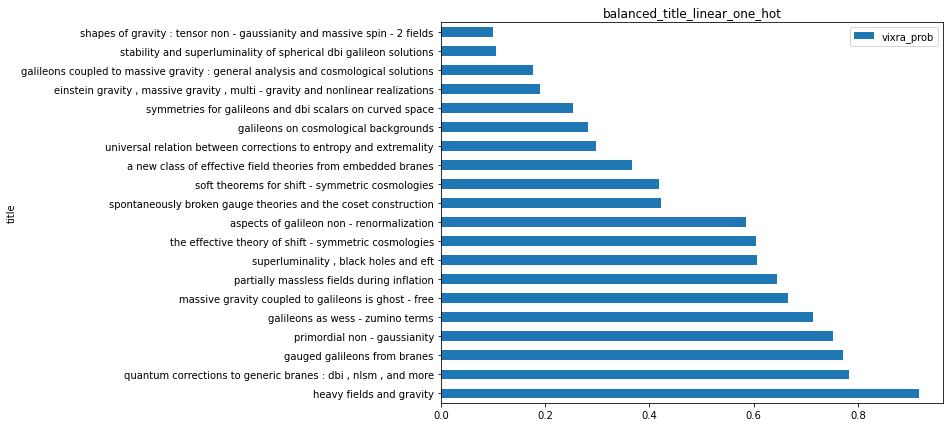

In [ ]:
goon_papers_df_barh = goon_papers_df.plot.barh(x='title', y='vixra_prob', title=PROJECT, figsize=(9, 7))
goon_papers_df_barh.figure.savefig(FOLDERNAME + f'/figures/{PROJECT}_goon_papers_preds.svg', bbox_inches='tight')